<a href="https://colab.research.google.com/github/cielo112/Oil-Portraits-Using-GAN/blob/main/art_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description

The aim of this project is to develop a state-of-the-art Generative Adversarial Network (GAN) capable of generating realistic and visually appealing oil paintings. By harnessing the power of deep learning and computer vision, this project seeks to enable artists, designers, and art enthusiasts to effortlessly create digital oil paintings that mimic the aesthetic and style of traditional oil painting techniques.

The project will involve the following key steps:

* Data Collection: A comprehensive dataset of high-quality oil paintings will be curated. This dataset will consist of diverse styles, genres, and subjects, including landscapes, portraits, still life, and abstract art. Careful consideration will be given to ensure a wide range of artistic techniques, brush strokes, and color palettes are represented.

* Model Architecture Design: An innovative GAN architecture will be designed to learn the intricate details and artistic elements present in oil paintings. The generator network will be responsible for producing realistic and coherent oil painting images, while the discriminator network will evaluate the generated images for authenticity. Various architectural components, such as convolutional and recurrent layers, will be explored and optimized to enhance the final output quality.

* Training Process: The GAN model will be trained on the curated dataset using advanced optimization techniques such as adversarial training, where the generator and discriminator networks compete against each other, improving their performance iteratively. To mitigate common challenges like mode collapse and training instability, additional regularization techniques and loss functions will be incorporated.

* Style Transfer and Customization: The trained GAN model will enable users to transfer various artistic styles to their own images or create entirely new oil paintings from scratch. 

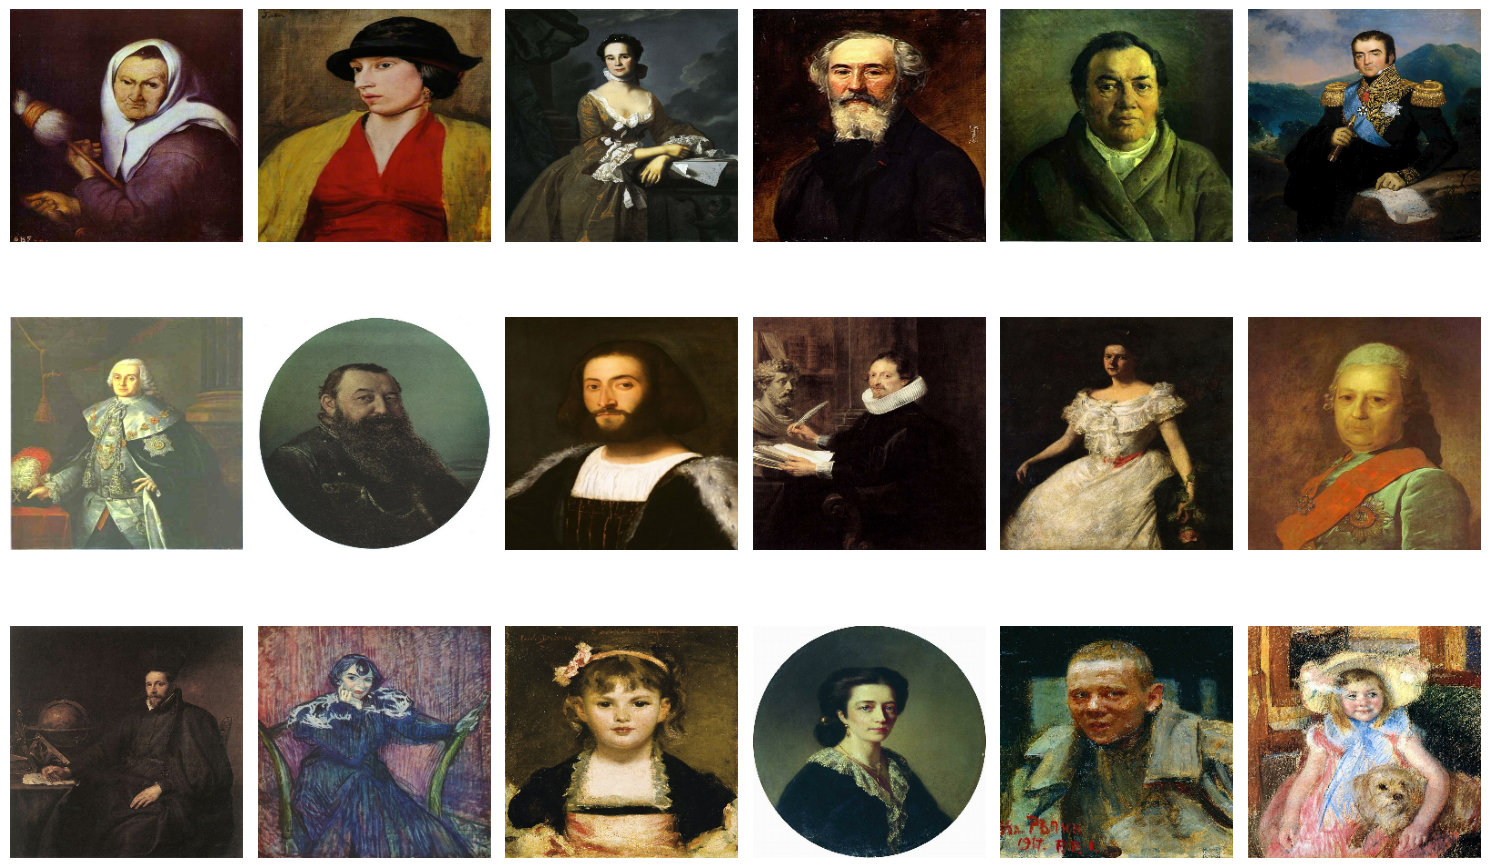

**Importing Libraries**

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm
import warnings
import zipfile
import PIL
from PIL import Image
warnings.filterwarnings("ignore")


**Loading the Data**

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

od.download(
    'https://www.kaggle.com/datasets/karnikakapoor/art-portraits?select=Portraits'
)

Skipping, found downloaded files in ".\art-portraits" (use force=True to force download)


In [4]:
path = r'C:\Users\John Carlo\Documents\Python\Generative Adverserial Networks\art-portraits\Portraits'
image_size = (64, 64)  # Desired image size
batch_size = 64

In [5]:
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(path,
          label_mode = None, batch_size = batch_size, image_size=image_size)

Found 4117 files belonging to 1 classes.


In [6]:
def show_image(data):
    '''This displays the image as the output'''
    fig, axs = plt.subplots(figsize=(15,10), nrows=3, ncols = 6)
    for i, images in zip(range(1,19),data.take(18)):
        axs = plt.subplot(3,6,i)
        axs.imshow(images[i].numpy().astype('uint8'))
        axs.axis('off')
    fig.tight_layout()

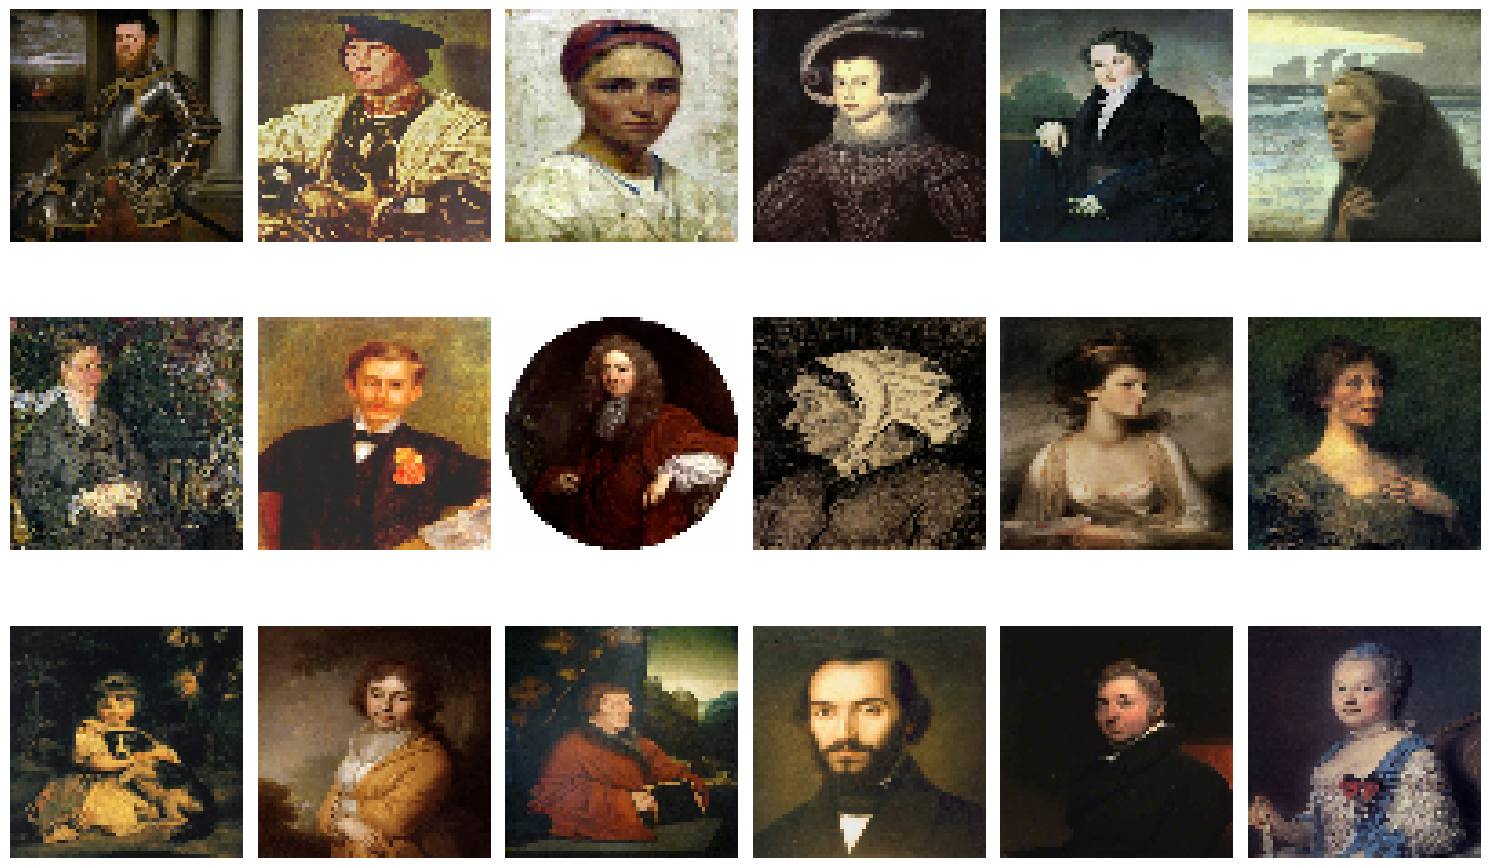

In [7]:
show_image(data)

In [8]:
data = data.map(lambda x: x/255.0)

# Building the GAN Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam

The `generator_builder` function creates and returns a generator model for a Generative Adversarial Network (GAN). The generator is responsible for generating new fake images from random noise (latent vectors).

Here's a description of the generator model architecture:

1. Input Layer:
   - The input to the generator is a random noise vector of size `latent_dim`.

2. Dense Layer:
   - The first layer is a Dense layer that takes the random noise vector and outputs a tensor with shape `(4*4*256)`. This reshaped tensor is treated as a 4x4 image with 256 channels.

3. Activation Layer:
   - After the Dense layer, a Leaky ReLU activation function with a slope of 0.2 is applied to introduce non-linearity.

4. Reshape Layer:
   - The output of the Dense layer is then reshaped to have a spatial shape of `(4, 4, 256)`.

5. Upsampling and Convolutional Layers:
   - The generator then upsamples the 4x4 image to progressively increase its resolution.
   - After each upsampling step, a Conv2D layer is used to learn more complex features.
   - Each Conv2D layer is followed by Batch Normalization with a momentum of 0.8 and a Leaky ReLU activation function (slope=0.2).

6. Final Convolutional Layer:
   - The last Conv2D layer reduces the number of channels to 3, representing the three color channels (RGB) of the generated image.
   - An activation function of `tanh` is applied to squash the pixel values between -1 and 1, suitable for image generation.

The overall architecture progressively upsamples the initial noise vector to generate an image with the desired resolution `g_resolution`. The model learns to map random noise to meaningful image representations.

The function returns the constructed generator model, which can be used as one component of the GAN model. When combined with the discriminator model and trained in an adversarial manner, the GAN learns to generate realistic images from random noise.

In [10]:
def generator_builder(latent_dim, g_resolution):
    '''This function creates the generator model given the
    latent dimension and the resolution'''

    generator = Sequential()

    #takes random values and reshapes to 4,4,256 image
    generator.add(Dense(4*4*256, input_dim = latent_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((4,4,256)))

    generator.add(UpSampling2D())
    generator.add(Conv2D(256,3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))

    generator.add(UpSampling2D())
    generator.add(Conv2D(256,3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))

    generator.add(UpSampling2D())
    generator.add(Conv2D(256,3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))

    generator.add(UpSampling2D())
    generator.add(Conv2D(128,3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))


    generator.add(Conv2D(3,3, padding='same'))
    generator.add(Activation('tanh'))


    return generator

In [11]:
test_model = generator_builder(100, 2)

In [12]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                          

In [13]:
generator = generator_builder(100,2)

(-0.5, 63.5, 63.5, -0.5)

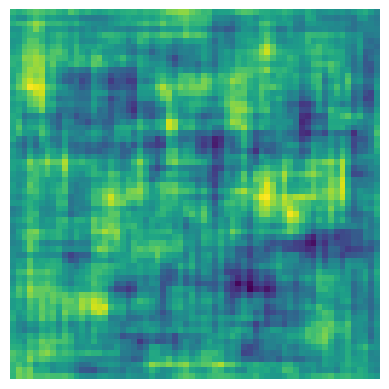

In [14]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, 100])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

# Building the Discriminator

The `discriminator_builder` function creates and returns a discriminator model for a Generative Adversarial Network (GAN). The discriminator is responsible for classifying input images as real or fake/generated.

Here's a description of the discriminator model architecture:

1. Input Layer:
   - The input shape of the images is `(64, 64, 3)`, representing images of size 64x64 pixels with 3 color channels (RGB).

2. Convolutional Layers:
   - The first Conv2D layer has 32 filters of size 3x3 and a stride of 2, which reduces the spatial dimensions of the image by half.
   - It applies Leaky ReLU activation with a slope of 0.2 to introduce non-linearity.
   - A Dropout layer with a dropout rate of 0.25 is added after each Conv2D layer to prevent overfitting.

3. Batch Normalization:
   - Batch normalization is applied after the second to fifth Conv2D layers with a momentum of 0.8.
   - Batch normalization helps stabilize and accelerate training by normalizing the outputs of the previous layer.

4. Flatten Layer:
   - After the last Conv2D layer, the output is flattened into a 1D vector.

5. Dense Layer:
   - The flattened vector is passed through a Dense layer with a single neuron and a sigmoid activation function.
   - The output of this layer will be a value between 0 and 1, representing the probability that the input image is real (1) or fake (0).

The overall architecture is designed to progressively downsample the input image while extracting meaningful features. This enables the discriminator to become more effective at distinguishing real images from fake ones.

The function returns the constructed discriminator model, which can be used as one component of the GAN model.

In [15]:
def discriminator_builder():
    '''This creates the discriminator for the GAN'''

    disc = Sequential()

    disc.add(Conv2D(32, 3, strides=2, input_shape=(64,64, 3), padding= 'same'))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))

    disc.add(Conv2D(64,3, strides=2, padding='same'))
    disc.add(BatchNormalization(momentum=0.8))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))

    disc.add(Conv2D(128,3, strides=2, padding='same'))
    disc.add(BatchNormalization(momentum=0.8))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))

    disc.add(Conv2D(256,3, strides=2, padding='same'))
    disc.add(BatchNormalization(momentum=0.8))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))

    disc.add(Conv2D(512,3, strides=2, padding='same'))
    disc.add(BatchNormalization(momentum=0.8))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))


    disc.add(Flatten())
    disc.add(Dense(1, activation= 'sigmoid'))

    return disc

In [16]:
discriminator = discriminator_builder()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                      

# Gan Compilation

This code defines a Generative Adversarial Network (GAN) class using TensorFlow's tf.keras.Model as the base class. A GAN is a type of neural network architecture consisting of two main components: a generator and a discriminator. The generator creates fake data, while the discriminator tries to distinguish between real and fake data. The GAN is trained in an adversarial manner, where the generator tries to improve its output to deceive the discriminator, and the discriminator tries to become better at distinguishing real from fake data.

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model

This code defines a Generative Adversarial Network (GAN) class using TensorFlow's `tf.keras.Model` as the base class. A GAN is a type of neural network architecture consisting of two main components: a generator and a discriminator. The generator creates fake data, while the discriminator tries to distinguish between real and fake data. The GAN is trained in an adversarial manner, where the generator tries to improve its output to deceive the discriminator, and the discriminator tries to become better at distinguishing real from fake data.

Here's a description of the key components of the `GAN` class:

1. `__init__` method:
   - Constructor for the `GAN` class.
   - Accepts three arguments: `discriminator`, `generator`, and `latent_dim`.
   - Initializes attributes for the discriminator, generator, and latent dimension.

2. `compile` method:
   - Configures the GAN for training by setting optimizers and loss function.
   - Accepts three arguments: `d_optimizer` (discriminator optimizer), `g_optimizer` (generator optimizer), and `loss_fn` (adversarial loss function).
   - Initializes optimizer and loss function attributes for both discriminator and generator.
   - Also creates two `tf.keras.metrics.Mean` instances for tracking discriminator and generator losses.

3. `metrics` property:
   - Returns a list containing the two metrics: discriminator loss and generator loss.

4. `train_step` method:
   - Performs a single training step for the GAN.
   - Accepts `real_images` as input, which are batches of real data to train the discriminator.
   - Generates random noise (latent vectors) with shape `(batch_size, latent_dim)` to feed into the generator.
   - The training step involves two parts:
      - Training the discriminator:
         - Combines the generated images (from the generator) with the real images and forms a single batch.
         - Assigns labels (ground truth) to the combined batch, where the first half is real (labeled as 1) and the second half is fake/generated (labeled as 0).
         - Adds a small amount of noise to the labels for better training stability.
         - Computes the discriminator loss based on the combined batch and its corresponding labels.
         - Computes gradients of the discriminator's trainable weights with respect to the discriminator loss.
         - Updates the discriminator's trainable weights using the gradients and the discriminator optimizer.
      - Training the generator:
         - Generates new random noise (latent vectors) with shape `(batch_size, latent_dim)`.
         - Assembles misleading labels (ground truth) for the generated images, all set to 0 (indicating they are real).
         - Computes the generator loss based on the generated images and the misleading labels.
         - Computes gradients of the generator's trainable weights with respect to the generator loss.
         - Updates the generator's trainable weights using the gradients and the generator optimizer.
   - Updates the metrics to keep track of the discriminator and generator losses.
   - Returns a dictionary containing the updated discriminator and generator losses.

This GAN class can be used for training a GAN model by passing appropriate discriminator and generator models, along with the latent dimension size, and then compiling and training the GAN using the `fit` method.

In [18]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()

        #Create attributes for the discr and gen
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()

        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        #generate the fake image
        generated_images = self.generator(seed)

        #combine generated image with the real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        #Assing labels to the generated and real images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        #Add noise to the labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        #Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

         # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


**Model Training**

In [19]:
#Define the epochs to be run
epochs = 200

#Setting the optimizers and the loss functions
g_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
d_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
loss_fn = BinaryCrossentropy()
latent_dim = 100

#Defining the GAN model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling the GAN
model.compile(d_optimizer=d_opt, g_optimizer=g_opt, loss_fn=loss_fn)


#Fitting the GAN
hist = model.fit(data, epochs=epochs)

Epoch 1/200
65/65 [==============================] - 215s 3s/step - d_loss: 0.6786 - g_loss: 0.7224
Epoch 2/200
65/65 [==============================] - 196s 3s/step - d_loss: 0.6853 - g_loss: 0.7533
Epoch 3/200
65/65 [==============================] - 194s 3s/step - d_loss: 0.6659 - g_loss: 0.8058
Epoch 4/200
65/65 [==============================] - 193s 3s/step - d_loss: 0.6827 - g_loss: 0.7931
Epoch 5/200
65/65 [==============================] - 193s 3s/step - d_loss: 0.6686 - g_loss: 0.7948
Epoch 6/200
65/65 [==============================] - 193s 3s/step - d_loss: 0.6548 - g_loss: 0.8212
Epoch 7/200
65/65 [==============================] - 193s 3s/step - d_loss: 0.6453 - g_loss: 0.8429
Epoch 8/200
65/65 [==============================] - 193s 3s/step - d_loss: 0.6458 - g_loss: 0.8642
Epoch 9/200
65/65 [==============================] - 193s 3s/step - d_loss: 0.6311 - g_loss: 0.9478
Epoch 10/200
65/65 [==============================] - 193s 3s/step - d_loss: 0.6305 - g_loss: 0.9665

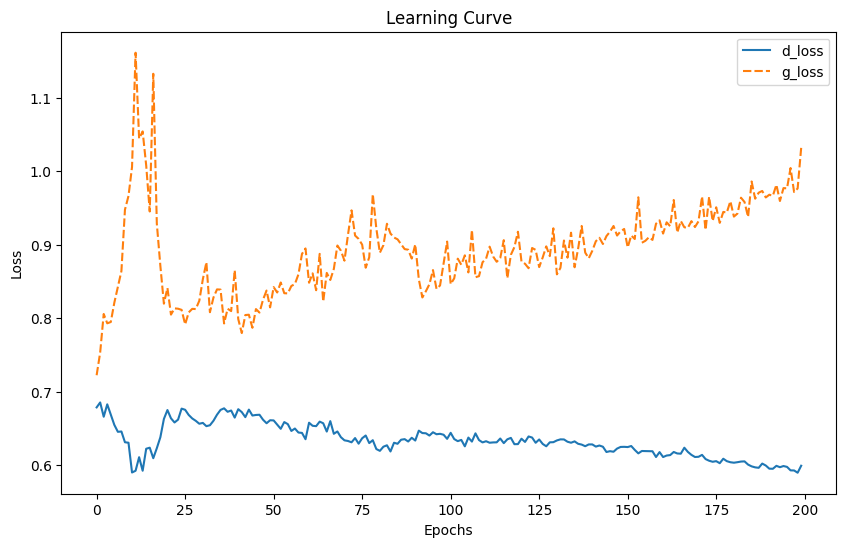

In [20]:
hist_df = pd.DataFrame(hist.history)
fig, axs =  plt.subplots(figsize=(10,6))
sns.lineplot(data=hist_df)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

In [21]:
import os

In [23]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator(num_img, latent_dim):
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save(os.path.join('images', "Portraits{:02d}.jpg".format(i)))

    return Generated_Paintings

#Generating images
Images = Potrait_Generator(num_img=18, latent_dim=100)

In [24]:
#Loading generated images
generated_path = r'C:\Users\John Carlo\Documents\Python\Generative Adverserial Networks\images'
portraits_generated = tf.keras.preprocessing.image_dataset_from_directory(generated_path, label_mode = None, batch_size=19)

Found 18 files belonging to 1 classes.


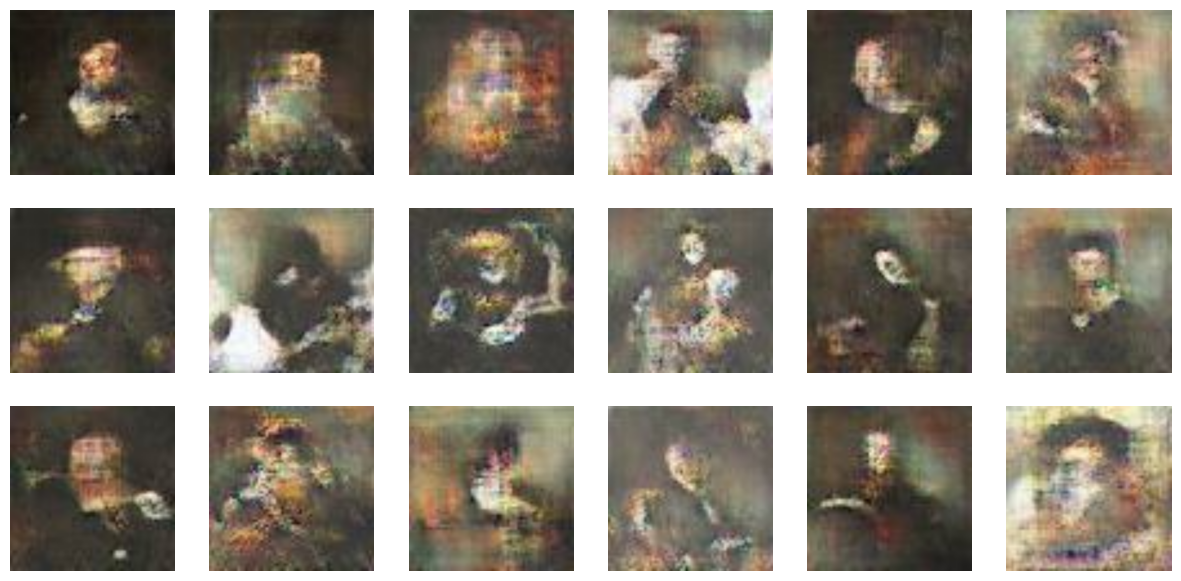

In [25]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset
Show_Img(portraits_generated)

In [31]:
generator.save('portrait_generator.h5')
discriminator.save('portrait_discriminator.h5')